## Imports

In [414]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from os import listdir
from os.path import isfile, join
from PIL import Image
from torchvision import datasets, models
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time as time
import copy
from torchvision.datasets import OxfordIIITPet
from torch.optim import lr_scheduler

from tqdm import tqdm

## Fields

In [415]:



num_classes = 37 #Number of classes in dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_size = 300
batch_size = 128

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

path = ""

## Methods

In [416]:
def set_parameter_requires_grad(model, feature_extracting):
    params_to_update = list(model.named_parameters())
    
    if feature_extracting:
        for name, param in params_to_update:
            param.requires_grad = False      
    else:
        
        for module, param in zip(model.modules(), model.parameters()):
            if isinstance(module, nn.BatchNorm2d):
                param.requires_grad = True
            else:
                param.requires_grad = False
            

def grid_search_params(model, feature_extracting, perc):
    params_to_update = list(model.named_parameters())
    
    i = 0
   
    for name, param in reversed(params_to_update):
        if (i/len(params_to_update)) < perc:
            param.requires_grad = True
        else:
            param.requires_grad = False
        i+=1
    
    for module, param in zip(model.modules(), model.parameters()):
        if isinstance(module, nn.BatchNorm2d):
            param.requires_grad = False
        
                       

def initialize_model(model_name, num_classes, feature_extracting): #Initialize Resnet

    if model_name == "resnet":

        model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True) 
        
        set_parameter_requires_grad(model, feature_extracting)
        
        num_ftrs = model.fc.in_features
        head = nn.Sequential(nn.BatchNorm1d(num_ftrs),
                             nn.ReLU(),
     ##                        nn.Dropout(0.25),#
      #          nn.Linear(num_ftrs, 512),
      #          nn.BatchNorm1d(512),
      #          nn.ReLU(),
     ##           nn.Dropout(0.25),#
      #          nn.Linear(512, 256),
      #          nn.BatchNorm1d(256),
       #         nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(num_ftrs,num_classes),

                )       
        #model.fc = nn.Linear(num_ftrs,num_classes) # Update last layer to binary classification (Dog/cat)
        model.fc = head #n.Linear(num_ftrs,num_classes) # Update last layer to binary classification (Dog/cat)
        input_size = 224 #"Finally, notice that inception_v3 requires the input size to be (299,299), whereas all of the other models expect (224,224)."
        model = model.to(device)
        
    return model, input_size



def readData(target_type):# = 'breeds'):
    breed_to_species = {0:0, 1:1, 2:1, 3:1, 4:1, 5:0, 6:0, 7:0, 8:1, 9:0, 10:1,
                    11:0, 12:1, 13:1, 14:1, 15:1, 16:1, 17:1, 18:1, 19:1, 20:0,
                    21:1, 22:1, 23:0, 24:1, 25:1, 26:0, 27:0, 28:1, 29:1, 30:1,
                    31:1, 32:0, 33:0, 34:1, 35:1, 36:1
                   }
    
    transform_train = T.Compose([
                           #T.Resize(256),
                            T.Resize(image_size),

                           T.CenterCrop(image_size),
                           T.RandomHorizontalFlip(p=0.3),
                           T.RandomVerticalFlip(p=0.3),
                           ##T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                           #T.RandomRotation(degrees=90),
                           T.ToTensor(),
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                           #T.RandomResizedCrop(size=image_size)
                          ])
    

    
    transform_test = T.Compose([T.Resize(image_size),
        #T.Resize(256),
                            T.CenterCrop(image_size),
                           T.ToTensor(),
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                          ])
    if target_type == 'species':
        target_function = (lambda x: breed_to_species.get(x))
    elif target_type == 'breeds':
        target_function = None
    else:
        raise Exception("Wrong target type")
        
    trainval = OxfordIIITPet(path,
                             target_types= "category",
                             transform=transform_train,
                             split = 'trainval',
                             target_transform = target_function
                            )
    test = OxfordIIITPet(path,
                         target_types= "category",
                         transform=transform_test,
                         split = 'test',
                         target_transform = target_function
                        )
                         
    #train, val = splitData(trainval, 0.95, 0.05)
    return trainval, test #train, val, test
    
def splitData(dataset,nrTrain,nrVal):
    len1 = int(nrTrain*len(dataset))
    len2 = int(len(dataset) - len1)
    train, val = torch.utils.data.random_split(dataset, [len1,len2])
    return train, val

def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))




In [417]:
def train_model(model, dataloaders, criterion, optimizer, scheduler = None, num_epochs=25):
    since = time.time()
    loss_history = []
    val_acc_history = []
    acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs)

                    
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step()

                # statistics
                running_loss += float(loss.item() * inputs.size(0))
                running_corrects += torch.sum(preds == labels.data)
                
            #if phase == 'train' and scheduler == None:
                #scheduler.step()
            

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            loss_history.append(epoch_loss)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            acc_history.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model, val_acc_history,loss_history,acc_history

In [418]:
def score(model, dataloader, criterion):
    running_corrects = 0

    with torch.no_grad():
        model.eval()
        for inputs, labels in tqdm(dataloader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloader.dataset)
    print('Acc: {:4f}'.format(acc))

## Model evaluation

In [419]:
train, val    = readData(
                            #target_type = 'species'
                            target_type = 'breeds'
                            )

In [420]:
#print(len(train),len(val))
#train_set, val_set = torch.utils.data.random_split(val, [3000, 669])
#train = train + train_set

3680 3669


In [421]:
#train, _ = splitData(train, 0.20, 0.8)
#val, _ = splitData(val, 0.20,0.8)

In [422]:
model,input_size = initialize_model(model_name = "resnet",
                                    num_classes = 37,
                                    feature_extracting = True)


dataloaders = {'train': torch.utils.data.DataLoader(train, batch_size=batch_size,
                                         shuffle=True, num_workers=0),
                                         
               'val': torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
                }



test_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
epochs = 10
#criterion = nn.L1Loss()
criterion = nn.CrossEntropyLoss()
#criterion = nn.HingeEmbeddingLoss()
#criterion = nn.MultiLabelMarginLoss() #svm, funkar dåligt
#criterion  = nn.BCEWithLogitsLoss() 
#criterion = torch.nn.MultiMarginLoss()

Using cache found in C:\Users\GTSA - Infinity/.cache\torch\hub\pytorch_vision_v0.10.0


In [423]:



optimizer = optim.Adam(model.parameters(),
                       lr=1e-3, 
                       #weight_decay=1e-5,
                       #betas=(0.9, 0.999),
                      )





scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=1e-2,
                                                steps_per_epoch=len(dataloaders['train']), epochs=epochs)


model, val_acc_history, loss_history, acc_history = train_model(model = model,
                                          num_epochs = epochs,
                                          dataloaders = dataloaders,
                                          criterion = criterion,
                                          optimizer = optimizer,
                                          scheduler = None #scheduler
                                        )

Epoch 0/9
----------
train Loss: 1.1778 Acc: 0.7251
val Loss: 0.3147 Acc: 0.9343
Epoch 1/9
----------
train Loss: 0.4277 Acc: 0.8856
val Loss: 0.2139 Acc: 0.9485
Epoch 2/9
----------
train Loss: 0.3397 Acc: 0.9007
val Loss: 0.1698 Acc: 0.9575
Epoch 3/9
----------
train Loss: 0.2906 Acc: 0.9168
val Loss: 0.1414 Acc: 0.9629
Epoch 4/9
----------
train Loss: 0.2467 Acc: 0.9284
val Loss: 0.1214 Acc: 0.9689
Epoch 5/9
----------
train Loss: 0.2195 Acc: 0.9317
val Loss: 0.1152 Acc: 0.9695
Epoch 6/9
----------
train Loss: 0.2151 Acc: 0.9305
val Loss: 0.1059 Acc: 0.9717
Epoch 7/9
----------
train Loss: 0.1917 Acc: 0.9436
val Loss: 0.0968 Acc: 0.9768
Epoch 8/9
----------
train Loss: 0.1843 Acc: 0.9415
val Loss: 0.0902 Acc: 0.9768
Epoch 9/9
----------
train Loss: 0.1814 Acc: 0.9433
val Loss: 0.0867 Acc: 0.9774
Training complete in 18m 37s
Best val Acc: 0.977378


In [424]:
score(model, test_dataloader, criterion)

100%|██████████| 115/115 [00:35<00:00,  3.22it/s]

Acc: 0.977378


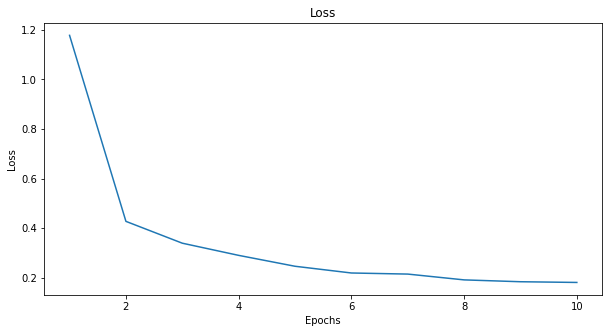

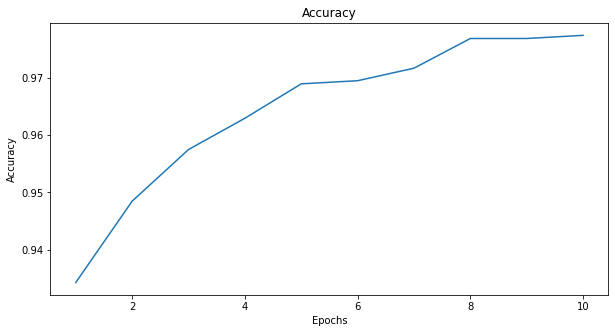

[0.934314527119106, 0.9484873262469338, 0.9574816026165168, 0.9629326792041428, 0.9689288634505315, 0.9694739711092941, 0.9716544017443446, 0.9768329245025893, 0.9768329245025893, 0.9773780321613519]


In [425]:

yvals = list(range(1,epochs+1))
newloss = []
newacc = []
for i in range(len(loss_history)):
    if i % 2 == 0:
        newloss.append(loss_history[i])
    else:
        newacc.append(acc_history[i].cpu().item())

plot1 = plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(yvals,newloss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plot2 = plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(yvals,newacc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

print(newacc)

In [426]:
torch.save(model.state_dict(), 'tensor')

In [427]:
"""layer_names = []
for idx, (name, param) in enumerate(model.named_parameters()):
    layer_names.append(name)

layer_names.reverse()

# learning rate
lr      = 1e-3
lr_mult = 0.9

# placeholder
parameters = []

# store params & learning rates
for idx, name in enumerate(layer_names):
    
    # display info
    print(f'{idx}: lr = {lr:.6f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]
    
    # update learning rate
    lr *= lr_mult

optimizer = optim.Adam(parameters)"""

"layer_names = []\nfor idx, (name, param) in enumerate(model.named_parameters()):\n    layer_names.append(name)\n\nlayer_names.reverse()\n\n# learning rate\nlr      = 1e-3\nlr_mult = 0.9\n\n# placeholder\nparameters = []\n\n# store params & learning rates\nfor idx, name in enumerate(layer_names):\n    \n    # display info\n    print(f'{idx}: lr = {lr:.6f}, {name}')\n    \n    # append layer parameters\n    parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],\n                    'lr':     lr}]\n    \n    # update learning rate\n    lr *= lr_mult\n\noptimizer = optim.Adam(parameters)"

## Finetuning

In [428]:
torch.cuda.empty_cache()
#model.load_state_dict(torch.load('tensor'))
set_parameter_requires_grad(model, False)
#grid_search_params(model, False, 0.5)

    
optimizer = optim.Adam(model.parameters(),
                       lr=1e-7, 
                       #weight_decay=1e-5,
                       #betas=(0.9, 0.999),
                      )

finetune_epochs = 7
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=1e-4,
                                                steps_per_epoch=len(dataloaders['train']),
                                                epochs=finetune_epochs)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

best_model, val_acc_history, loss_history, acc_history = train_model(model = model,
                                          num_epochs = finetune_epochs,
                                          dataloaders = dataloaders,
                                          criterion = criterion,
                                          optimizer = optimizer,
                                          scheduler = scheduler
                                        )

Epoch 0/6
----------
train Loss: 0.1490 Acc: 0.9543
val Loss: 0.0642 Acc: 0.9820
Epoch 1/6
----------
train Loss: 0.1336 Acc: 0.9572
val Loss: 0.0694 Acc: 0.9806
Epoch 2/6
----------
train Loss: 0.1013 Acc: 0.9699
val Loss: 0.0515 Acc: 0.9856
Epoch 3/6
----------
train Loss: 0.0639 Acc: 0.9822
val Loss: 0.0475 Acc: 0.9866
Epoch 4/6
----------
train Loss: 0.0398 Acc: 0.9898
val Loss: 0.0438 Acc: 0.9864
Epoch 5/6
----------
train Loss: 0.0322 Acc: 0.9924
val Loss: 0.0422 Acc: 0.9872
Epoch 6/6
----------
train Loss: 0.0228 Acc: 0.9955
val Loss: 0.0409 Acc: 0.9877
Training complete in 19m 47s
Best val Acc: 0.987735


In [429]:
score(best_model, test_dataloader, criterion)

100%|██████████| 115/115 [00:31<00:00,  3.70it/s]

Acc: 0.987735


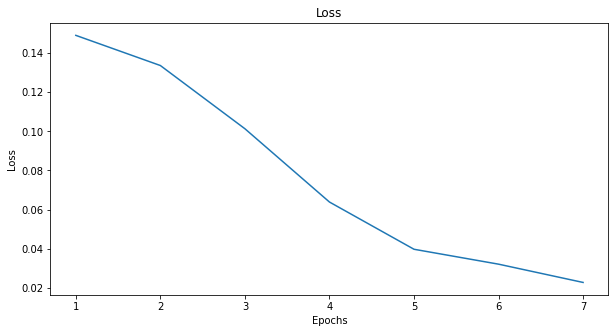

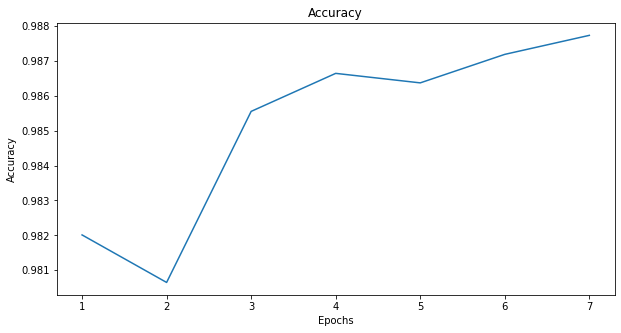

[0.982011447260834, 0.9806486781139275, 0.9855546470427909, 0.9866448623603162, 0.9863723085309349, 0.9871899700190788, 0.9877350776778414]


In [430]:
yvals = list(range(1,finetune_epochs+1))
newloss = []
newacc = []
for i in range(len(loss_history)):
    if i % 2 == 0:
        newloss.append(loss_history[i])
    else:
        newacc.append(acc_history[i].cpu().item())

plot1 = plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(yvals,newloss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

plot2 = plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(yvals,newacc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

print(newacc)

## Grid search layer params config

In [431]:

"""model.load_state_dict(torch.load('tensor'))
#set_parameter_requires_grad(model, False)
grid_search_params(model, False, 0.25)

optimizer = optim.Adam(model.parameters(),
                      lr=1e-7, 
                      weight_decay=1e-5,
                      betas=(0.9, 0.999),
                      )

finetune_epochs = 7
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=1e-5,
                                                steps_per_epoch=len(dataloaders['train']),
                                                epochs=finetune_epochs)

best_model, val_acc_history, loss_history, acc_history = train_model(model = model,
                                          num_epochs = finetune_epochs,
                                          dataloaders = dataloaders,
                                          criterion = criterion,
                                          optimizer = optimizer,
                                          scheduler = scheduler
                                        )
"""

"model.load_state_dict(torch.load('tensor'))\n#set_parameter_requires_grad(model, False)\ngrid_search_params(model, False, 0.25)\n\noptimizer = optim.Adam(model.parameters(),\n                      lr=1e-7, \n                      weight_decay=1e-5,\n                      betas=(0.9, 0.999),\n                      )\n\nfinetune_epochs = 7\nscheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,\n                                                max_lr=1e-5,\n                                                steps_per_epoch=len(dataloaders['train']),\n                                                epochs=finetune_epochs)\n\nbest_model, val_acc_history, loss_history, acc_history = train_model(model = model,\n                                          num_epochs = finetune_epochs,\n                                          dataloaders = dataloaders,\n                                          criterion = criterion,\n                                          optimizer = optimizer,\n         

In [432]:
        counter = 0
        for module, param in zip(model.modules(), model.parameters()):
            
            if isinstance(module, nn.BatchNorm2d):
                counter += 1
                print(module)
            else:
                param.requires_grad = False

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(128, eps=1e-05, momentu